In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, Subset, random_split
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=64, scale=(0.8, 1.0)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.STL10(root='./data', split='train', download=True, transform=train_transform)
unlabeled_dataset = datasets.STL10(root='./data', split='unlabeled', download=True, transform=train_transform)
test_dataset = datasets.STL10(root='./data', split='test', download=True, transform=test_transform)
val_dataset = datasets.STL10(root='./data', split='train', download=True, transform=test_transform)

num_labeled = 1000
random_indices = random.sample(range(len(train_dataset)), num_labeled)
labeled_dataset = Subset(train_dataset, random_indices)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


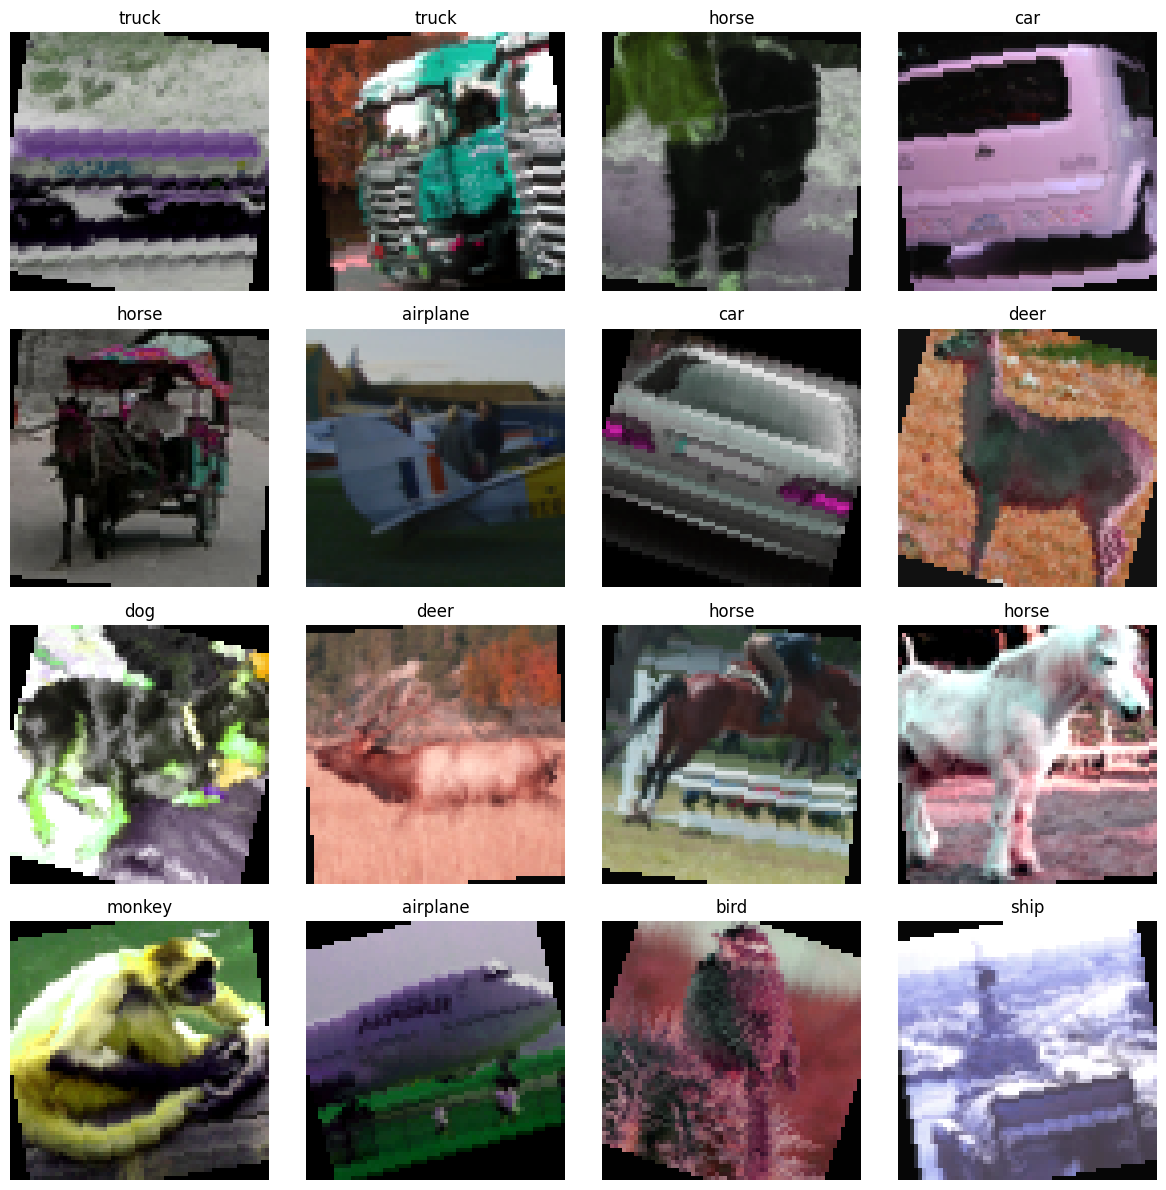

In [3]:
def denormalize(img):
    img = img * 0.5 + 0.5  
    return img

def show_images(dataset, num_images=16):
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    images = images.numpy()
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten()
    
    if hasattr(dataset, 'classes'):
        class_names = dataset.classes
    elif hasattr(dataset, 'dataset') and hasattr(dataset.dataset, 'classes'):
        class_names = dataset.dataset.classes
    else:
        class_names = None 
    
    for img, label, ax in zip(images, labels, axes):
        img = np.transpose(denormalize(img), (1, 2, 0))
        ax.imshow(img)
        if class_names is not None:
            ax.set_title(f'{class_names[label]}')
        else:
            ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

show_images(labeled_dataset)

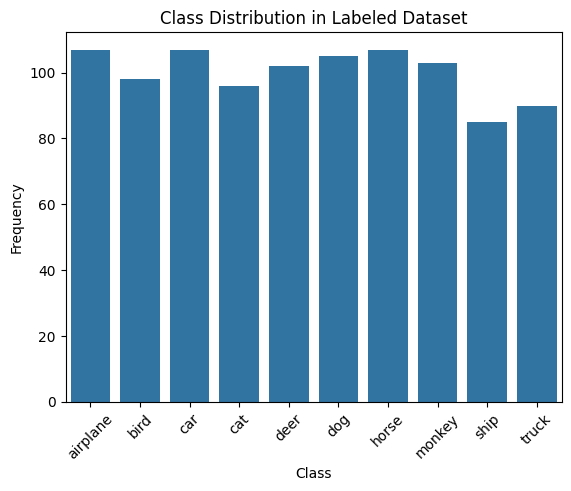

In [4]:
def plot_class_distribution(dataset, title):
    labels = [label for _, label in dataset]
    class_counts = np.bincount(labels)
    if hasattr(dataset, 'classes'):
        class_names = dataset.classes
    elif isinstance(dataset, Subset):
        if hasattr(dataset.dataset, 'classes'):
            class_names = dataset.dataset.classes
        else:
            class_names = [str(i) for i in range(len(class_counts))]
    else:
        class_names = [str(i) for i in range(len(class_counts))]
    
    sns.barplot(x=class_names, y=class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(labeled_dataset, 'Class Distribution in Labeled Dataset')

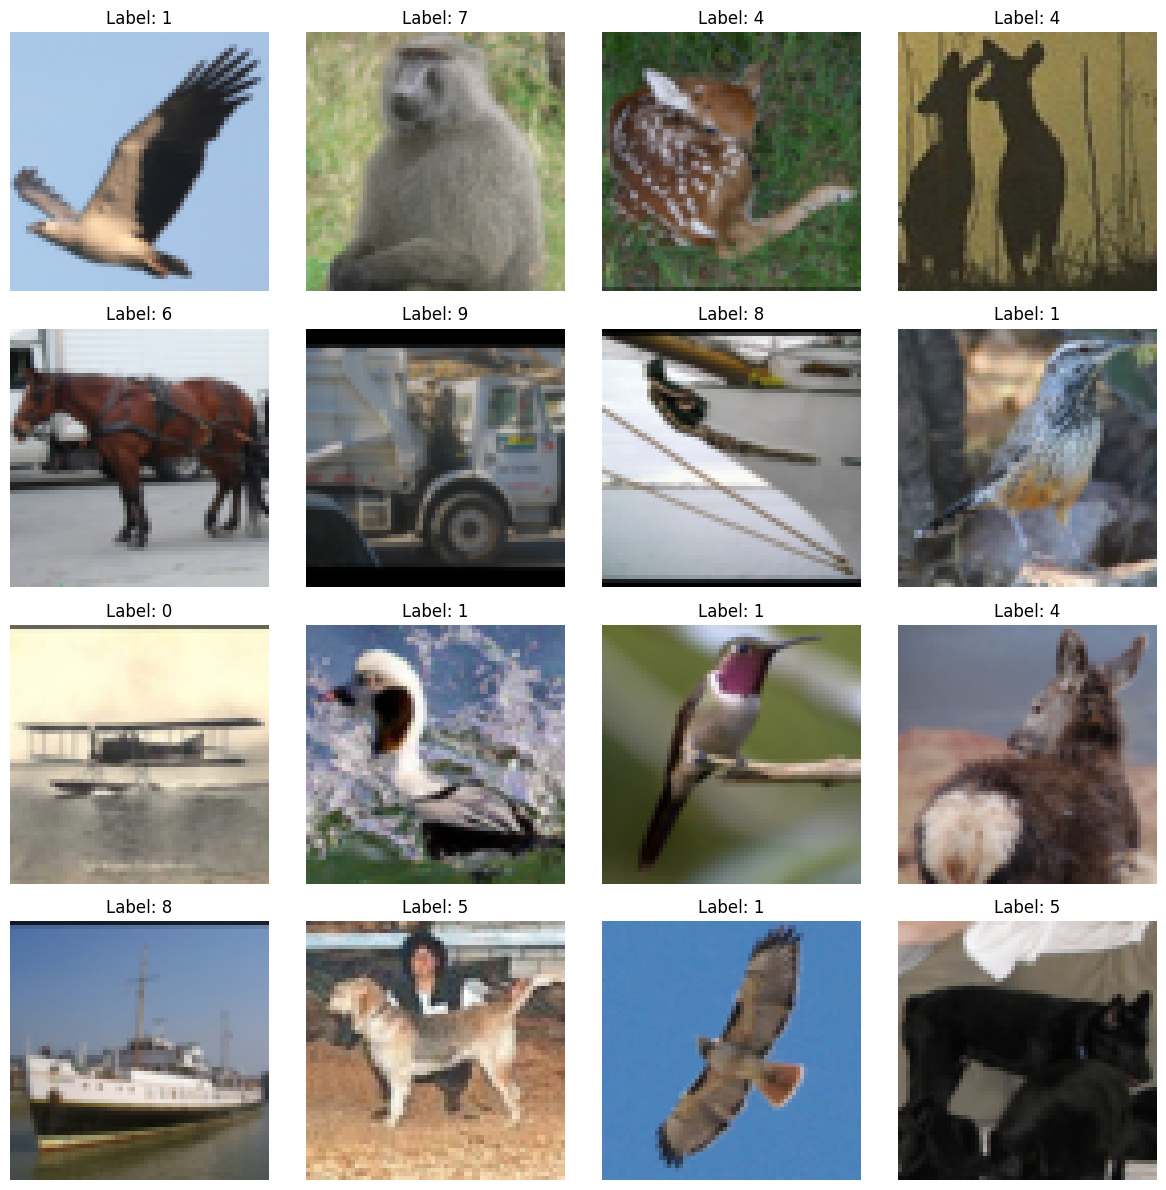

In [5]:
train_size = int(0.8 * num_labeled)
val_size = num_labeled - train_size
train_subset, val_subset = random_split(labeled_dataset, [train_size, val_size])

val_subset.dataset.dataset.transform = test_transform 

batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

show_images(train_subset)


In [6]:
def create_model():
    model = models.resnet18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 10)
    return model.to(device)

teacher = create_model()
student = create_model()

criterion = nn.CrossEntropyLoss()
optimizer_teacher = optim.Adam(teacher.parameters(), lr=0.0005, weight_decay=1e-4)
optimizer_student = optim.Adam(student.parameters(), lr=0.0005, weight_decay=1e-4)

c:\Users\dhawal bansal\Desktop\ML_project_kanak\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\dhawal bansal\Desktop\ML_project_kanak\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Teacher Epoch 1/10, Train Loss: 1.6205, Val Loss: 2.3046
Teacher Epoch 2/10, Train Loss: 0.3735, Val Loss: 1.4776
Teacher Epoch 3/10, Train Loss: 0.1069, Val Loss: 1.1305
Teacher Epoch 4/10, Train Loss: 0.0368, Val Loss: 1.1326
Teacher Epoch 5/10, Train Loss: 0.0172, Val Loss: 1.0408
Teacher Epoch 6/10, Train Loss: 0.0057, Val Loss: 1.0591
Teacher Epoch 7/10, Train Loss: 0.0249, Val Loss: 1.0969
Teacher Epoch 8/10, Train Loss: 0.0152, Val Loss: 1.1897
Teacher Epoch 9/10, Train Loss: 0.0150, Val Loss: 1.0983
Teacher Epoch 10/10, Train Loss: 0.0120, Val Loss: 1.1489


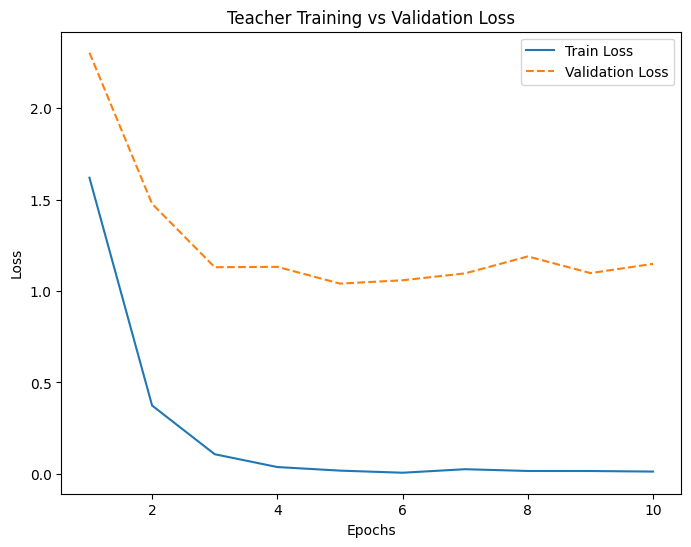

In [7]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=10, model_type="Teacher"):
    model.train()
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"{model_type} Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_type} Training vs Validation Loss")
    plt.legend()
    plt.show()
    
    return model

teacher = train_model(teacher, train_loader, val_loader, optimizer_teacher, criterion, epochs=10, model_type="Teacher")


In [8]:
def generate_pseudo_labels(model, dataloader, threshold=0.7):
    model.eval()
    pseudo_data = []
    pseudo_labels = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            max_probs, preds = torch.max(probs, dim=1)
            mask = max_probs > threshold
            if mask.any():
                pseudo_data.append(inputs[mask].cpu())
                pseudo_labels.append(preds[mask].cpu())
    if pseudo_data:
        return torch.cat(pseudo_data, dim=0), torch.cat(pseudo_labels, dim=0)
    else:
        return torch.tensor([]), torch.tensor([])

pseudo_data, pseudo_labels = generate_pseudo_labels(teacher, unlabeled_loader, threshold=0.7)
print(f'Generated {len(pseudo_labels)} pseudo-labeled examples.')

Generated 62688 pseudo-labeled examples.


Student Epoch 1/10, Train Loss: 0.5335, Val Loss: 1.1756
Student Epoch 2/10, Train Loss: 0.3611, Val Loss: 1.2284
Student Epoch 3/10, Train Loss: 0.2746, Val Loss: 1.3330
Student Epoch 4/10, Train Loss: 0.2196, Val Loss: 1.4015
Student Epoch 5/10, Train Loss: 0.1841, Val Loss: 1.4559
Student Epoch 6/10, Train Loss: 0.1547, Val Loss: 1.4904
Student Epoch 7/10, Train Loss: 0.1319, Val Loss: 1.3880
Student Epoch 8/10, Train Loss: 0.1236, Val Loss: 1.3617
Student Epoch 9/10, Train Loss: 0.1156, Val Loss: 1.4717
Student Epoch 10/10, Train Loss: 0.1062, Val Loss: 1.7201


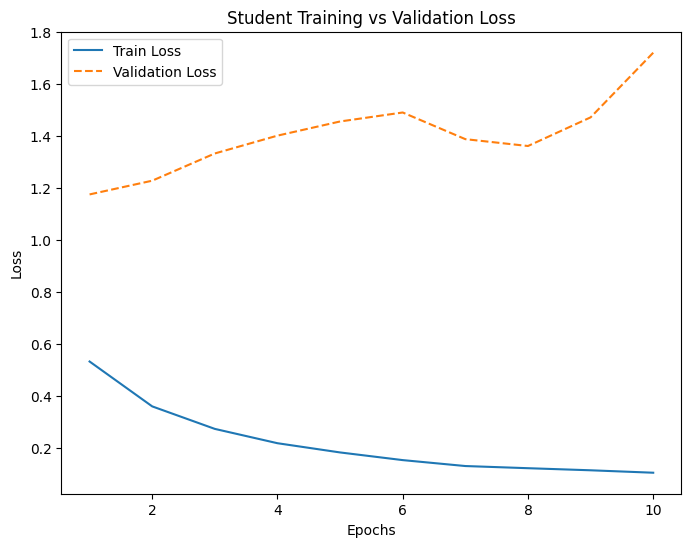

In [ ]:
def train_student(model, train_loader, val_loader, optimizer, criterion, pseudo_data, pseudo_labels, epochs=10):
    model.train()
    if len(pseudo_labels) > 0:
        pseudo_dataset = torch.utils.data.TensorDataset(pseudo_data, pseudo_labels)
        pseudo_loader = DataLoader(pseudo_dataset, batch_size=batch_size, shuffle=True)
    else:
        pseudo_loader = []
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            model.train()
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        if len(pseudo_labels) > 0:
            for inputs, labels in pseudo_loader:
                model.train()
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        
        total_batches = len(train_loader) + (len(pseudo_loader) if len(pseudo_labels) > 0 else 0)
        train_loss = running_loss / total_batches
        train_losses.append(train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Student Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
    plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss", linestyle='dashed')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Student Training vs Validation Loss")
    plt.legend()
    plt.show()
    
    return model

student = train_student(student, train_loader, val_loader, optimizer_student, criterion, pseudo_data, pseudo_labels, epochs=10)

torch.save(student.state_dict(), 'STL_Safe.pt')


Test Accuracy: 61.79%


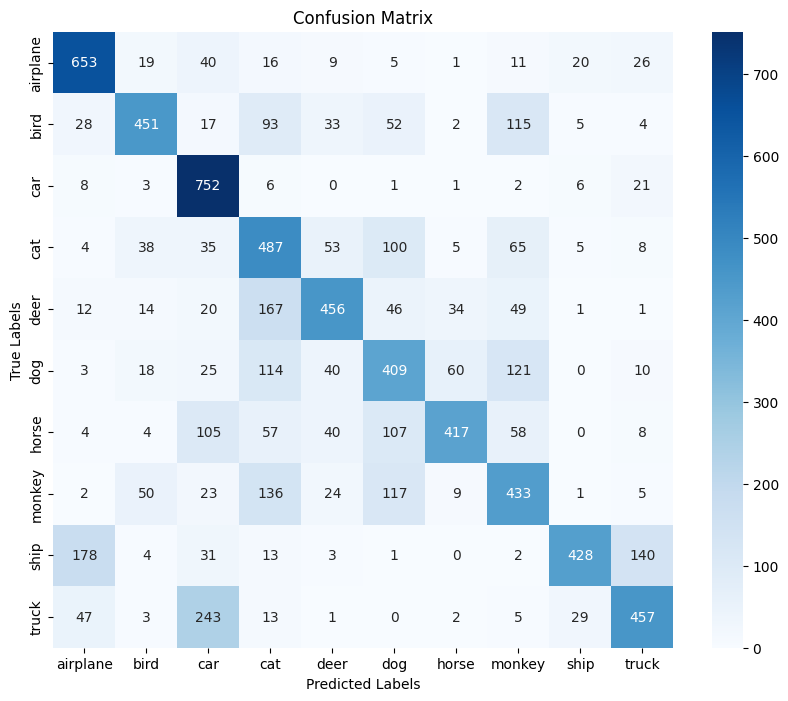


Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.82      0.75       800
        bird       0.75      0.56      0.64       800
         car       0.58      0.94      0.72       800
         cat       0.44      0.61      0.51       800
        deer       0.69      0.57      0.63       800
         dog       0.49      0.51      0.50       800
       horse       0.79      0.52      0.63       800
      monkey       0.50      0.54      0.52       800
        ship       0.86      0.54      0.66       800
       truck       0.67      0.57      0.62       800

    accuracy                           0.62      8000
   macro avg       0.65      0.62      0.62      8000
weighted avg       0.65      0.62      0.62      8000



In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    if class_names is not None:
        report = classification_report(all_labels, all_preds, target_names=class_names)
    else:
        report = classification_report(all_labels, all_preds)
    print('\nClassification Report:')
    print(report)

class_names = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

evaluate_model(student, test_loader, class_names)